<a href="https://colab.research.google.com/github/mathena828/MNIST_AutoencoderClassifier/blob/main/MNIST_AutoencoderClassfier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [26]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from keras.datasets import mnist
import keras.backend as K
from keras.engine.topology import Layer, InputSpec
from keras.layers import Dense, Input
from keras.models import Model
from keras.optimizers import SGD
from keras import callbacks
from keras.initializers import VarianceScaling

from sklearn.cluster import KMeans
from sklearn.metrics import normalized_mutual_info_score, adjusted_rand_score, confusion_matrix
from scipy.optimize import linear_sum_assignment

In [3]:
# Load MNIST dataset.
(x_train, y_train), (x_test, y_test) = mnist.load_data()
# Pre-process the data.
x = np.concatenate((x_train, x_test))
y = np.concatenate((y_train, y_test))
x = x.reshape((x.shape[0], -1))
x = np.divide(x, 255.0)
n_clusters = len(np.unique(y))

11493376/11490434 [==============================] - 0s 0us/step


In [4]:
np.random.seed(10)
# Scale the results between 0 (no mutual correlation) and 1 (perfect correlation).
normalized_mutual_info = normalized_mutual_info_score
# Find the simillarity measure between two clusterings.
adjusted_rand = adjusted_rand_score
# Use the Hungarian Algorithm to assign labels to each cluster.
def hungarian(y_true, y_pred):
    y_true = y_true.astype(np.int64)
    assert y_pred.size == y_true.size
    dimesion = max(y_pred.max(), y_true.max()) + 1
    weights = np.zeros((dimesion, dimesion), dtype=np.int64)
    for i in range(y_pred.size):
        weights[y_pred[i], y_true[i]] += 1
    index = linear_sum_assignment(weights.max() - weights)
    index = np.asarray(index)
    index = np.transpose(index)
    return sum([weights[i, j] for i, j in index])*1.0 / y_pred.size

In [5]:
# Build an autoencoder.
def autoencoder(dimensions, act='relu', init='glorot_uniform'):
    n_stacks = len(dimensions) - 1
    input_img = Input(shape=(dimensions[0],))
    x = input_img
    for i in range(n_stacks-1):
        x = Dense(dimensions[i + 1], activation=act, kernel_initializer=init)(x)
    encoded = Dense(dimensions[-1], kernel_initializer=init)(x)
    x = encoded
    for i in range(n_stacks-1, 0, -1):
        x = Dense(dimensions[i], activation=act, kernel_initializer=init)(x)
    x = Dense(dimensions[0], kernel_initializer=init)(x)
    decoded = x
    return Model(inputs=input_img, outputs=decoded), Model(inputs=input_img, outputs=encoded)

In [6]:
# Set hyperparameters.
dimensions = [x.shape[-1], 500, 500, 2000, 10]
init = VarianceScaling(scale=1.0/3.0, mode='fan_in', distribution='uniform')
pretrain_optimizer = SGD(lr=1, momentum=0.9)
pretrain_epochs = 30
batch_size = 64

In [7]:
# Train the autoencoder.
autoencoder, encoder = autoencoder(dimensions, init=init)
autoencoder.compile(optimizer=pretrain_optimizer, loss='mse')
autoencoder.fit(x, x, batch_size=batch_size, epochs=pretrain_epochs) 

Epoch 1/30
1094/1094 [==============================] - 52s 48ms/step - loss: 0.0430
Epoch 2/30
1094/1094 [==============================] - 52s 48ms/step - loss: 0.0232
Epoch 3/30
1094/1094 [==============================] - 53s 48ms/step - loss: 0.0199
Epoch 4/30
1094/1094 [==============================] - 53s 48ms/step - loss: 0.0182
Epoch 5/30
1094/1094 [==============================] - 53s 49ms/step - loss: 0.0170
Epoch 6/30
1094/1094 [==============================] - 51s 47ms/step - loss: 0.0162
Epoch 7/30
1094/1094 [==============================] - 57s 53ms/step - loss: 0.0155
Epoch 8/30
1094/1094 [==============================] - 53s 49ms/step - loss: 0.0150
Epoch 9/30
1094/1094 [==============================] - 54s 49ms/step - loss: 0.0145
Epoch 10/30
1094/1094 [==============================] - 53s 48ms/step - loss: 0.0142
Epoch 11/30
1094/1094 [==============================] - 56s 52ms/step - loss: 0.0138
Epoch 12/30
1094/1094 [==============================] - 54s 49

In [8]:
autoencoder.save_weights('autoencoder_weights.h5')

In [13]:
autoencoder.load_weights('autoencoder_weights.h5')

In [14]:
# Build a clustering layer that can be added to the encoder.
class ClusteringLayer(Layer):
    def __init__(self, n_clusters, weights=None, alpha=1.0, **kwargs):
        if 'input_shape' not in kwargs and 'input_dim' in kwargs:
            kwargs['input_shape'] = (kwargs.pop('input_dim'),)
        super(ClusteringLayer, self).__init__(**kwargs)
        self.n_clusters = n_clusters
        self.alpha = alpha
        self.initial_weights = weights
        self.input_spec = InputSpec(ndim=2)
    def build(self, input_shape):
        assert len(input_shape) == 2
        input_dim = input_shape[1]
        self.input_spec = InputSpec(dtype=K.floatx(), shape=(None, input_dim))
        self.clusters = self.add_weight(shape=(self.n_clusters, input_dim), initializer='glorot_uniform')
        if self.initial_weights is not None:
            self.set_weights(self.initial_weights)
            del self.initial_weights
        self.built = True
    def call(self, inputs, **kwargs):
        vectors = 1.0/(1.0+(K.sum(K.square(K.expand_dims(inputs, axis=1)-self.clusters), axis=2)/self.alpha))
        vectors **= (self.alpha + 1.0)/2.0
        vectors = K.transpose(K.transpose(vectors)/K.sum(vectors, axis=1))
        return vectors
    def compute_output_shape(self, input_shape):
        assert input_shape and len(input_shape) == 2
        return input_shape[0], self.n_clusters
    def get_config(self):
        config = {'n_clusters': self.n_clusters}
        base_config = super(ClusteringLayer, self).get_config()
        return dict(list(base_config.items()) + list(config.items()))

clustering_layer = ClusteringLayer(n_clusters, name='cluster_layer')(encoder.output)
model = Model(inputs=encoder.input, outputs=clustering_layer)
model.compile(optimizer=SGD(0.01, 0.9), loss='kld')

In [15]:
# Initialize the clustering layer's weights using K-means.
kmeans = KMeans(n_clusters=n_clusters, n_init=20)
y_pred = kmeans.fit_predict(encoder.predict(x))
y_pred_last = np.copy(y_pred)
model.get_layer(name='cluster_layer').set_weights([kmeans.cluster_centers_])

In [17]:
# Compute for the target distribution.
def target_distribution(vectors):
    weight = vectors**2/vectors.sum(0)
    return (weight.T/weight.sum(1)).T

In [18]:
# Train the model with the clustering layer.
loss = 0
index = 0
max_iterations = 5000
update_interval = 100
index_array = np.arange(x.shape[0])
tolerance = 0.001 
for i in range(int(max_iterations)):
    if i%update_interval == 0:
        vectors = model.predict(x, verbose=0)
        target = target_distribution(vectors)
        y_pred = vectors.argmax(1)
        if y is not None:
            acc = np.round(hungarian(y, y_pred), 5)
            nmi = np.round(normalized_mutual_info(y, y_pred), 5)
            rnd = np.round(adjusted_rand(y, y_pred), 5)
            loss = np.round(loss, 5)
            print('Iteration %d: acc = %.5f, nmi = %.5f, rnd = %.5f' % (i, acc, nmi, rnd), ' loss=', loss)
        delta_label = np.sum(y_pred != y_pred_last).astype(np.float32)/y_pred.shape[0]
        y_pred_last = np.copy(y_pred)
        if i > 0 and delta_label < tolerance:
            print('delta_label ', delta_label, '< tolerance', tolerance)
            break
    ind = index_array[index*batch_size: min((index+1) * batch_size, x.shape[0])]
    loss = model.train_on_batch(x=x[ind], y=target[ind])
    index = index + 1 if (index + 1) * batch_size <= x.shape[0] else 0

Iteration 0: acc = 0.90203, nmi = 0.80371, rnd = 0.79523  loss= 0
Iteration 100: acc = 0.90630, nmi = 0.80792, rnd = 0.80437  loss= 0.07589
Iteration 200: acc = 0.90893, nmi = 0.81146, rnd = 0.81107  loss= 0.16173
Iteration 300: acc = 0.91509, nmi = 0.82217, rnd = 0.82423  loss= 0.20065
Iteration 400: acc = 0.92297, nmi = 0.83503, rnd = 0.83984  loss= 0.26606
Iteration 500: acc = 0.92726, nmi = 0.84207, rnd = 0.84864  loss= 0.26867
Iteration 600: acc = 0.93079, nmi = 0.84797, rnd = 0.85565  loss= 0.26793
Iteration 700: acc = 0.93443, nmi = 0.85469, rnd = 0.86282  loss= 0.26741
Iteration 800: acc = 0.93611, nmi = 0.85758, rnd = 0.86629  loss= 0.27852
Iteration 900: acc = 0.93854, nmi = 0.86186, rnd = 0.87115  loss= 0.26825
Iteration 1000: acc = 0.93909, nmi = 0.86339, rnd = 0.87253  loss= 0.25945
Iteration 1100: acc = 0.94116, nmi = 0.86585, rnd = 0.87604  loss= 0.24967
Iteration 1200: acc = 0.94256, nmi = 0.86866, rnd = 0.87900  loss= 0.25163
Iteration 1300: acc = 0.94307, nmi = 0.8701

In [19]:
model.save_weights('classifier.h5')

In [20]:
# Evaluate the classifier.
vectors = model.predict(x, verbose=0)
target = target_distribution(vectors) 
y_pred = vectors.argmax(1)
if y is not None:
    acc = np.round(hungarian(y, y_pred), 5)
    nmi = np.round(normalized_mutual_info(y, y_pred), 5)
    ari = np.round(adjusted_rand(y, y_pred), 5)
    loss = np.round(loss, 5)
    print('Classifier: acc = %.5f, nmi = %.5f, ari = %.5f' % (acc, nmi, ari), ' loss=', loss)

Classifier: acc = 0.95071, nmi = 0.88517, ari = 0.89566  loss= 0.14713


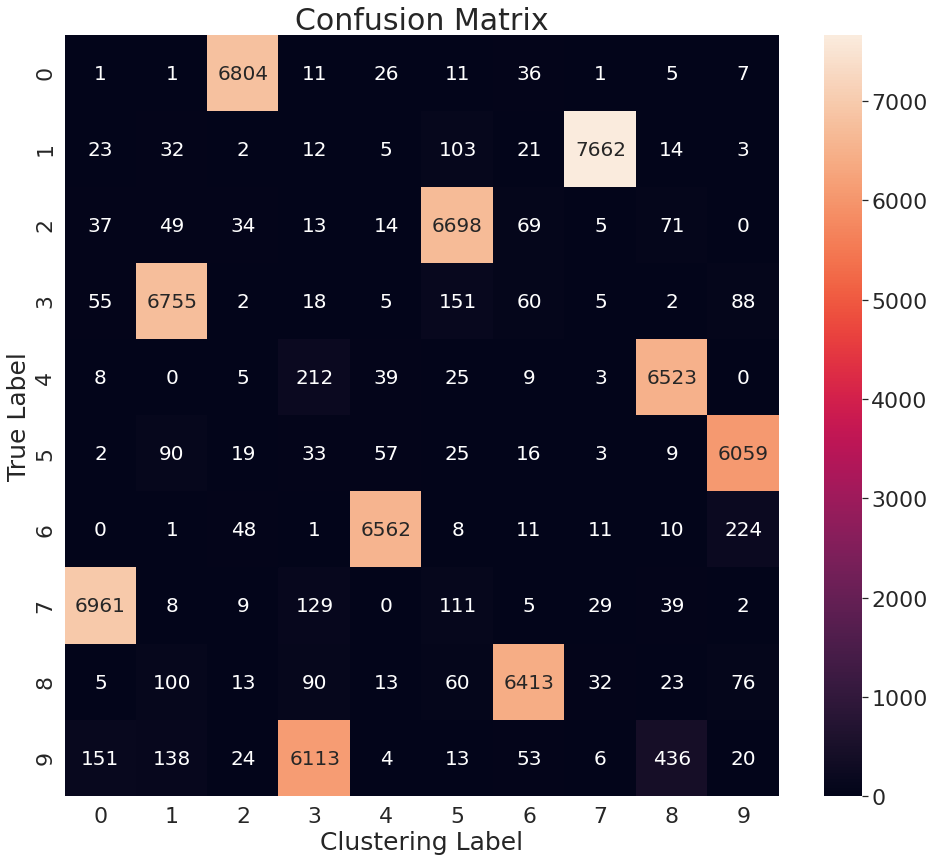

In [30]:
sns.set(font_scale=2)
conf = sklearn.metrics.confusion_matrix(y, y_pred)
plt.figure(figsize=(16, 14))
sns.heatmap(conf, annot=True, fmt="d", annot_kws={"size": 20});
plt.title("Confusion Matrix", fontsize=30)
plt.ylabel('True Label', fontsize=25)
plt.xlabel('Clustering Label', fontsize=25)
plt.show()

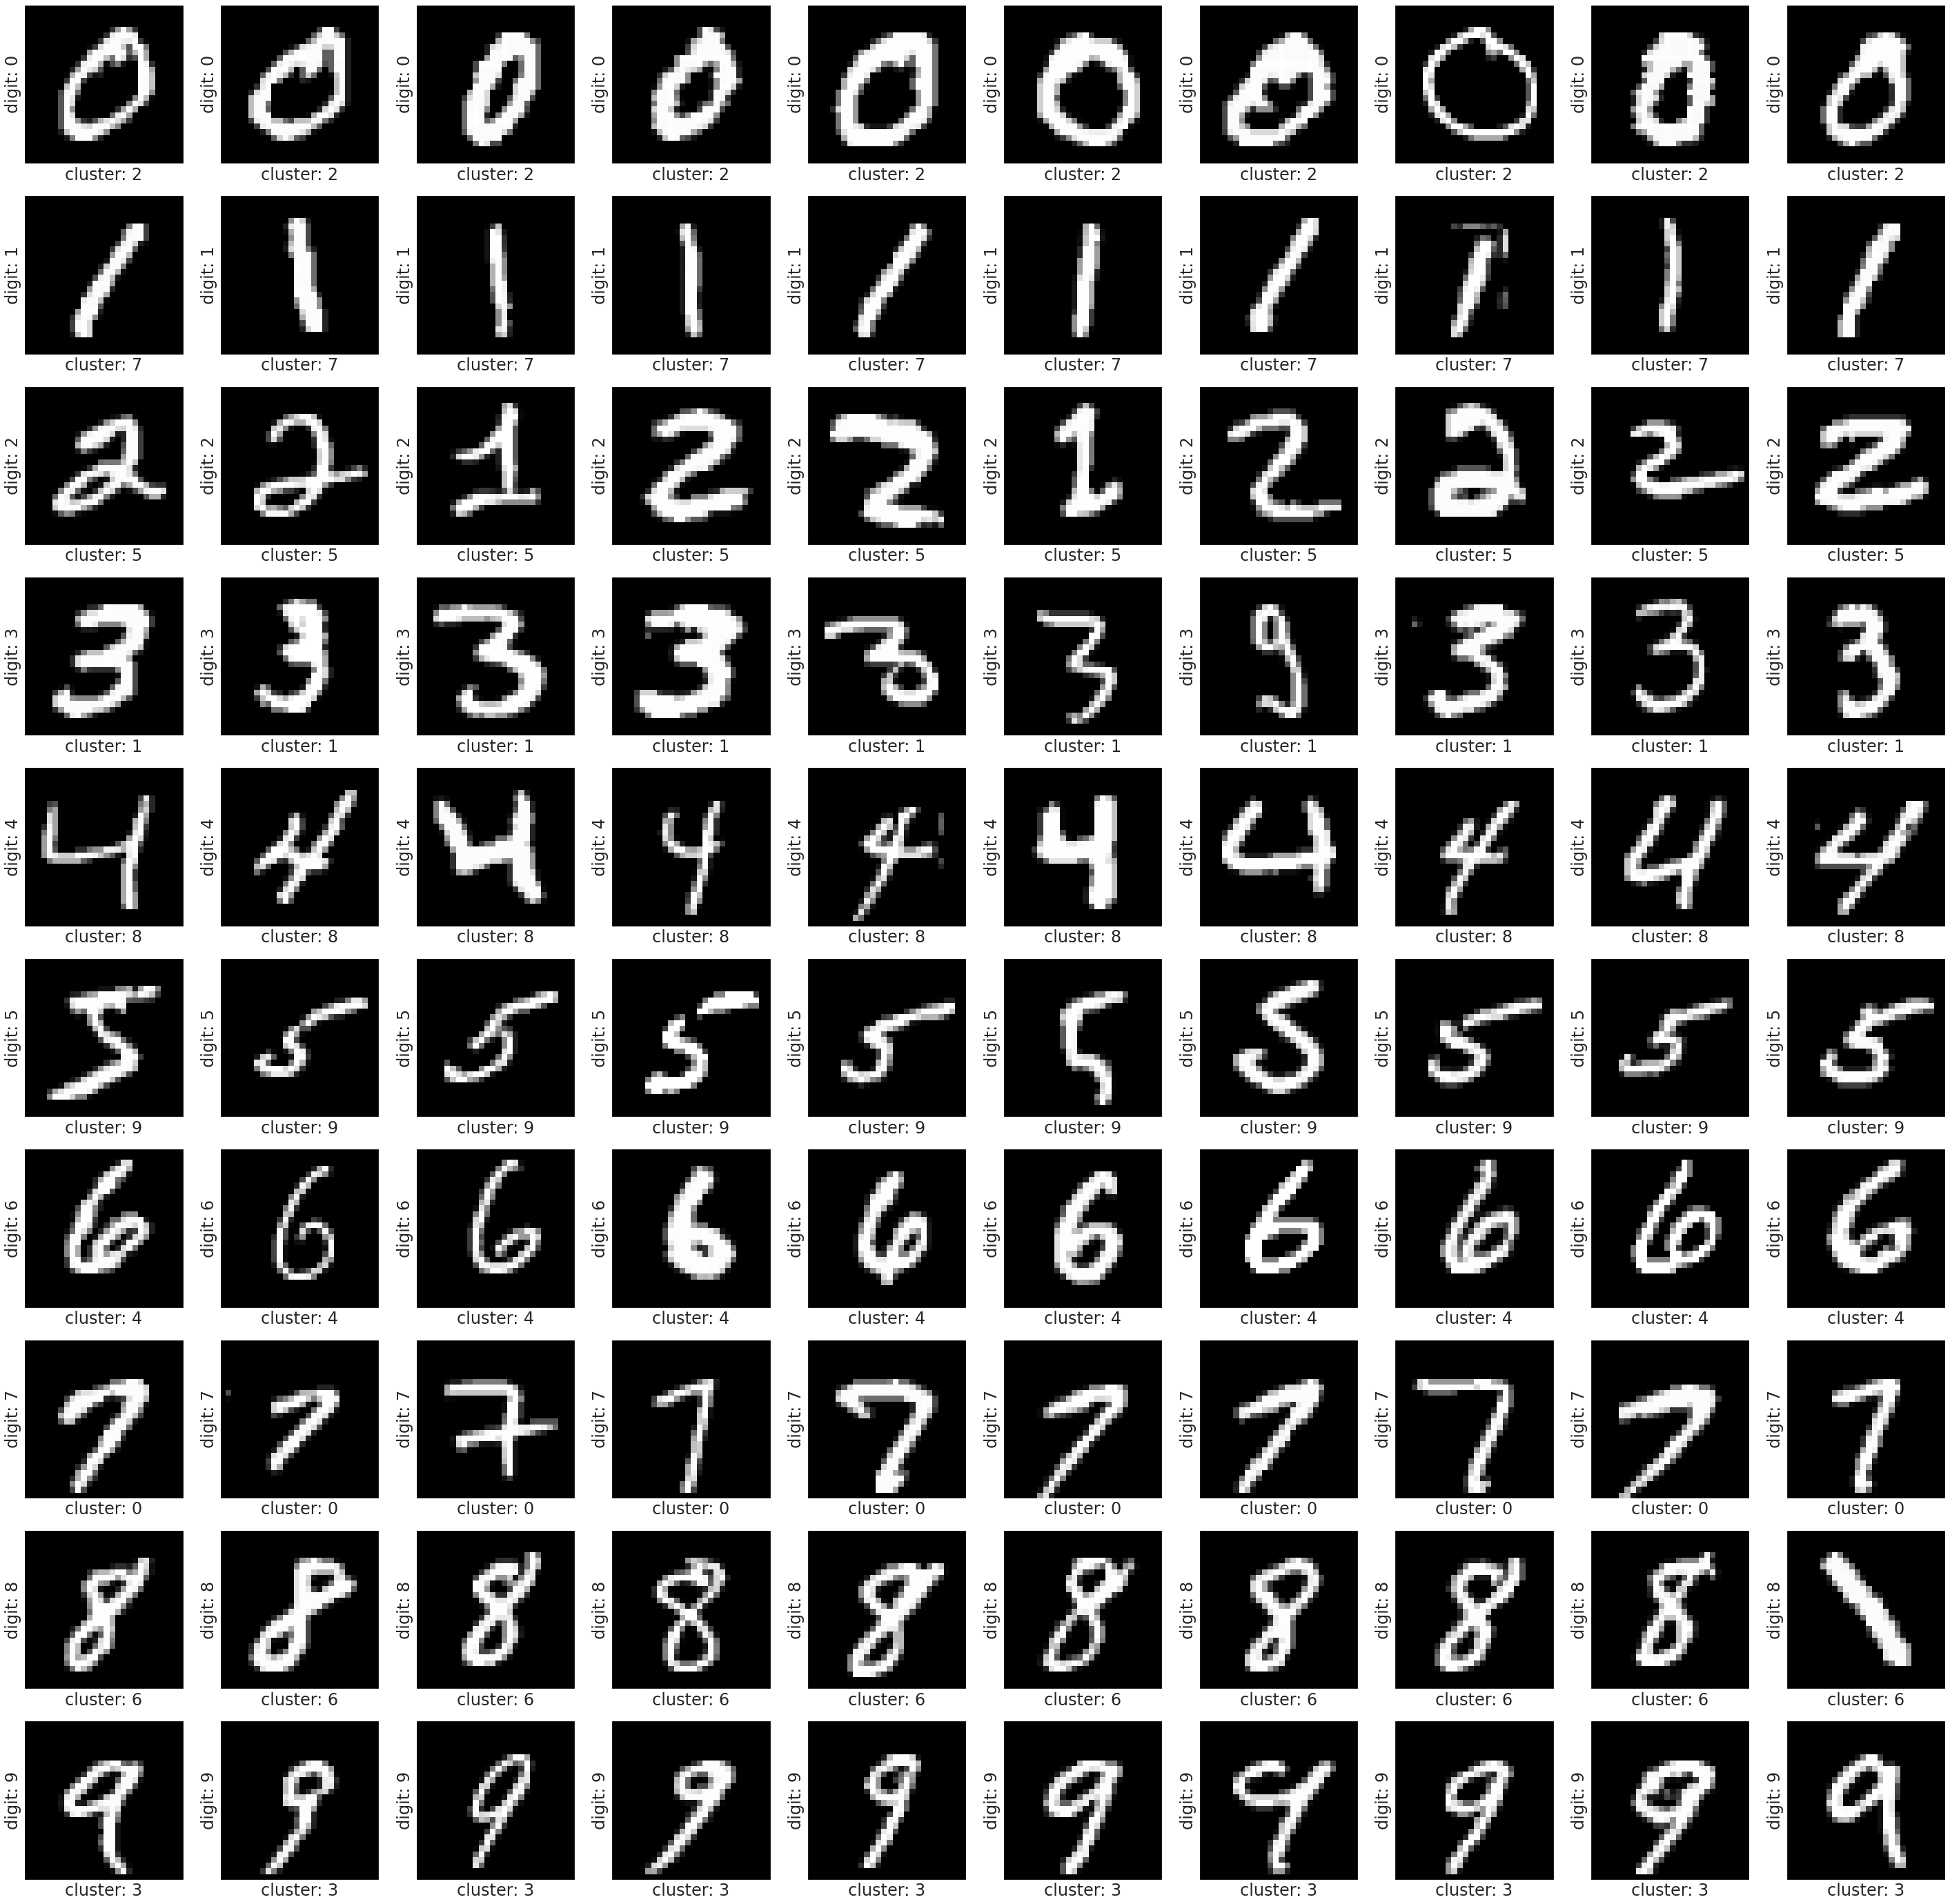

In [31]:
figure = plt.figure(figsize=(50,50))
for i in range(10):
    cluster = conf[i].argmax()
    for j, k in enumerate(x[y_pred == cluster][0:10]):
        figure.add_subplot(10, 10, 10*i+j+1)
        plt.imshow(k.reshape((28,28)))
        plt.gray()
        plt.xticks([])
        plt.yticks([])
        plt.xlabel('cluster: '+str(cluster))
        plt.ylabel('digit: '+str(i))